In [2]:
!unzip /content/KomNET_Face_Image_Dataset_from_Various_Media.zip

Archive:  /content/KomNET_Face_Image_Dataset_from_Various_Media.zip
   creating: KomNET  Face Image Dataset from Various Media/
   creating: KomNET  Face Image Dataset from Various Media/Digital Camera/
   creating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamera_i made parasya maharta/
  inflating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamera_i made parasya maharta/10_kamera_i made parasya maharta_ (1).JPG  
  inflating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamera_i made parasya maharta/10_kamera_i made parasya maharta_ (10).JPG  
  inflating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamera_i made parasya maharta/10_kamera_i made parasya maharta_ (11).JPG  
  inflating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamera_i made parasya maharta/10_kamera_i made parasya maharta_ (12).JPG  
  inflating: KomNET  Face Image Dataset from Various Media/Digital Camera/10_kamer

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

# Set environment variable to suppress TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

IMAGE_SIZE = 168
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "KomNET_Face_Image_Dataset_from_Various_Media",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3615 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Digital Camera', 'Mobile Phone', 'Social Media']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 168, 168, 3)
[2 0 2 0 1 1 0 1 0 2 0 1 2 2 1 1 1 1 0 2 0 2 2 1 0 2 0 2 2 0 2 1]


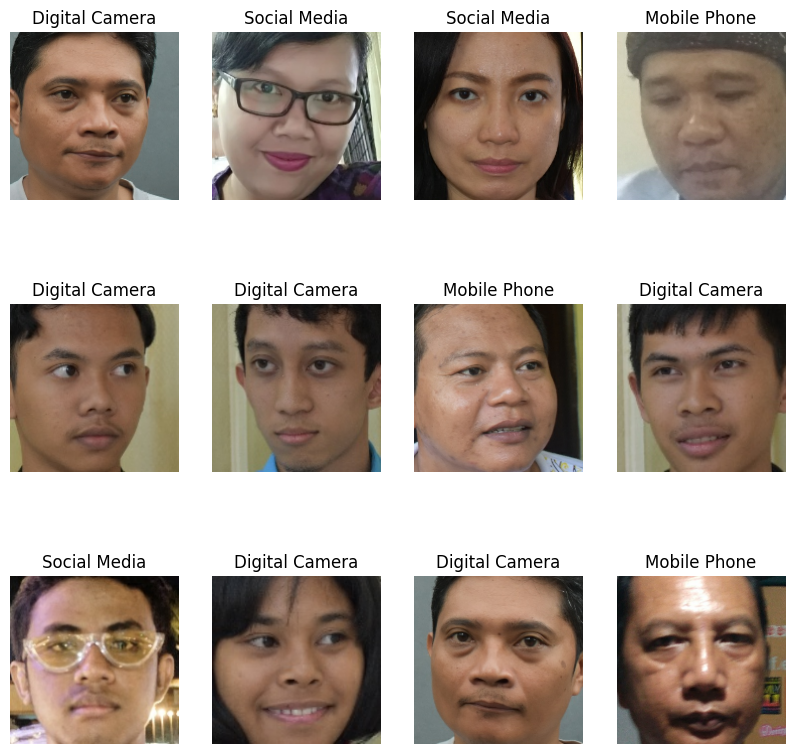

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
train_size = 0.8
print(len(dataset)*train_size)

train_ds = dataset.take(54)
print(len(train_ds))

test_ds = dataset.skip(54)
print(len(test_ds))

val_size = 0.1
print(len(dataset)*val_size)

val_ds = test_ds.take(6)
print(len(val_ds))

test_ds = test_ds.skip(6)
print(len(test_ds))

90.4
54
59
11.3
6
53


In [11]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_size = 0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return test_ds,val_ds,test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) # makes model robust(data augumentation)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 168, 168, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 168, 168, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 166, 166, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 83, 83, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 81, 81, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 40, 40, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
12/12 [==============================] - 18s 297ms/step - loss: 1.1952 - accuracy: 0.3394 - val_loss: 1.0872 - val_accuracy: 0.3665
Epoch 2/50
12/12 [==============================] - 1s 43ms/step - loss: 1.1396 - accuracy: 0.3368 - val_loss: 1.1300 - val_accuracy: 0.3239
Epoch 3/50
12/12 [==============================] - 0s 39ms/step - loss: 1.1191 - accuracy: 0.3133 - val_loss: 1.0899 - val_accuracy: 0.3665
Epoch 4/50
12/12 [==============================] - 0s 39ms/step - loss: 1.0965 - accuracy: 0.3551 - val_loss: 1.0854 - val_accuracy: 0.3750
Epoch 5/50
12/12 [==============================] - 0s 40ms/step - loss: 1.1091 - accuracy: 0.3812 - val_loss: 1.1010 - val_accuracy: 0.4261
Epoch 6/50
12/12 [==============================] - 1s 43ms/step - loss: 1.1020 - accuracy: 0.3473 - val_loss: 1.0863 - val_accuracy: 0.3182
Epoch 7/50
12/12 [==============================] - 1s 45ms/step - loss: 1.0912 - accuracy: 0.3446 - val_loss: 1.0723 - val_accuracy: 0.3892
Epoch 8/50


In [17]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 4s 13ms/step - loss: 0.4770 - accuracy: 0.8225


In [18]:
scores

[0.4770055115222931, 0.8224543333053589]

In [19]:
history

In [20]:
len(history.history['accuracy'])

50

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

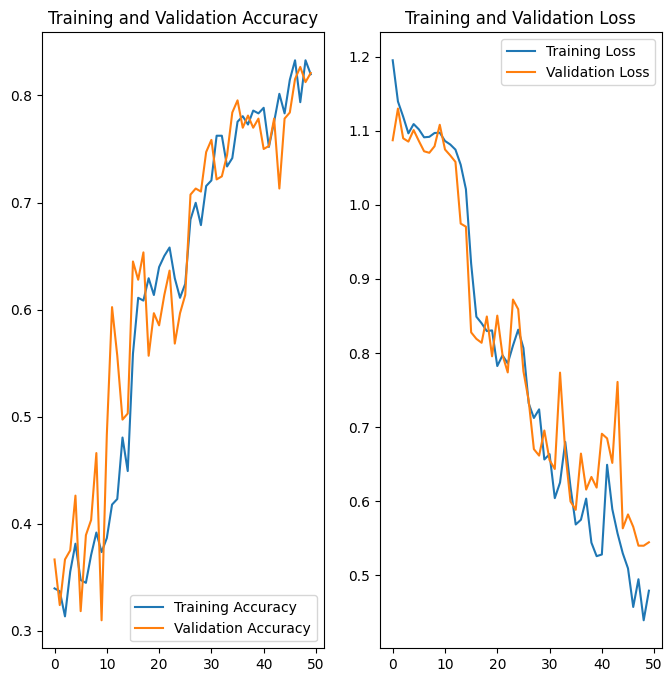

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label : Mobile Phone
1/1 [==============================] - 0s 335ms/step
predicted label: Digital Camera


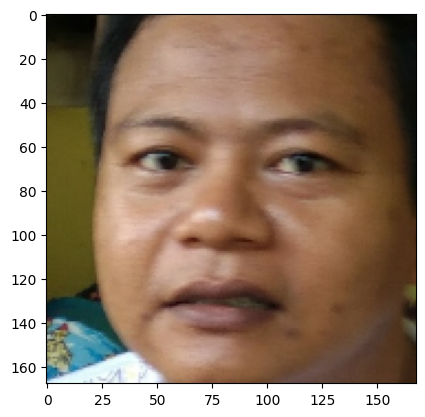

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label :", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 94ms/step


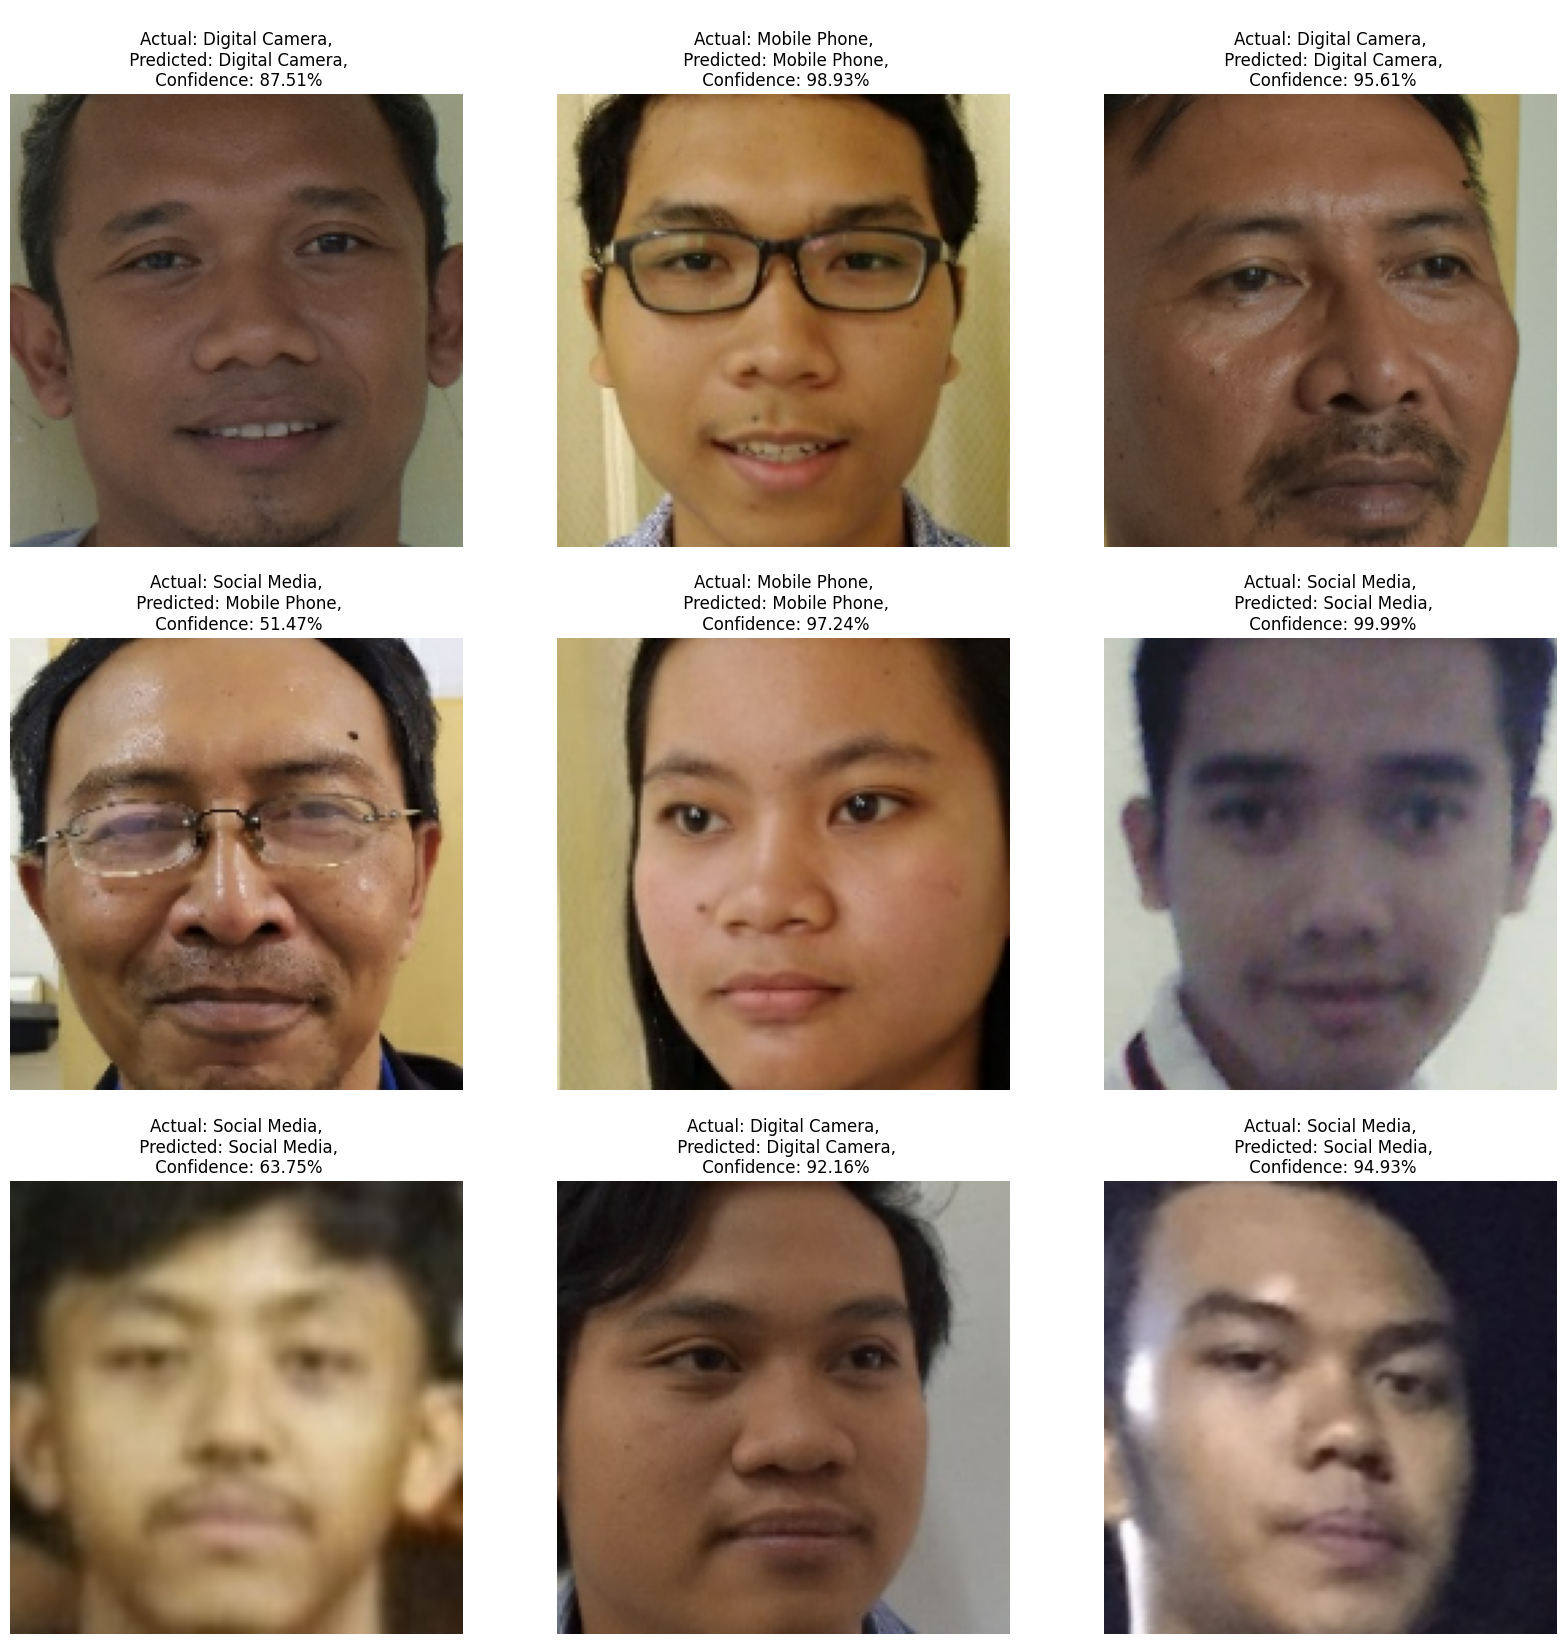

In [25]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"\nActual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
    plt.axis("off")